## Calculando Largura de vias

A intenção aqui é experimentar uma metodoloogia para se calcular a larura de vias dadas as seguintes feições:
* Um polígono da via
* Uma linha aproximada ao trajeto central da via
* Poligono com as quadras adjacentes a via

Para tanto disponibilizamos um arquivo que podemos acessar assim:

In [65]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [66]:
df_pvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='poligono-de-vias')

In [67]:
df_lvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='logradouros')

In [68]:
df_quadras = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='quadras')

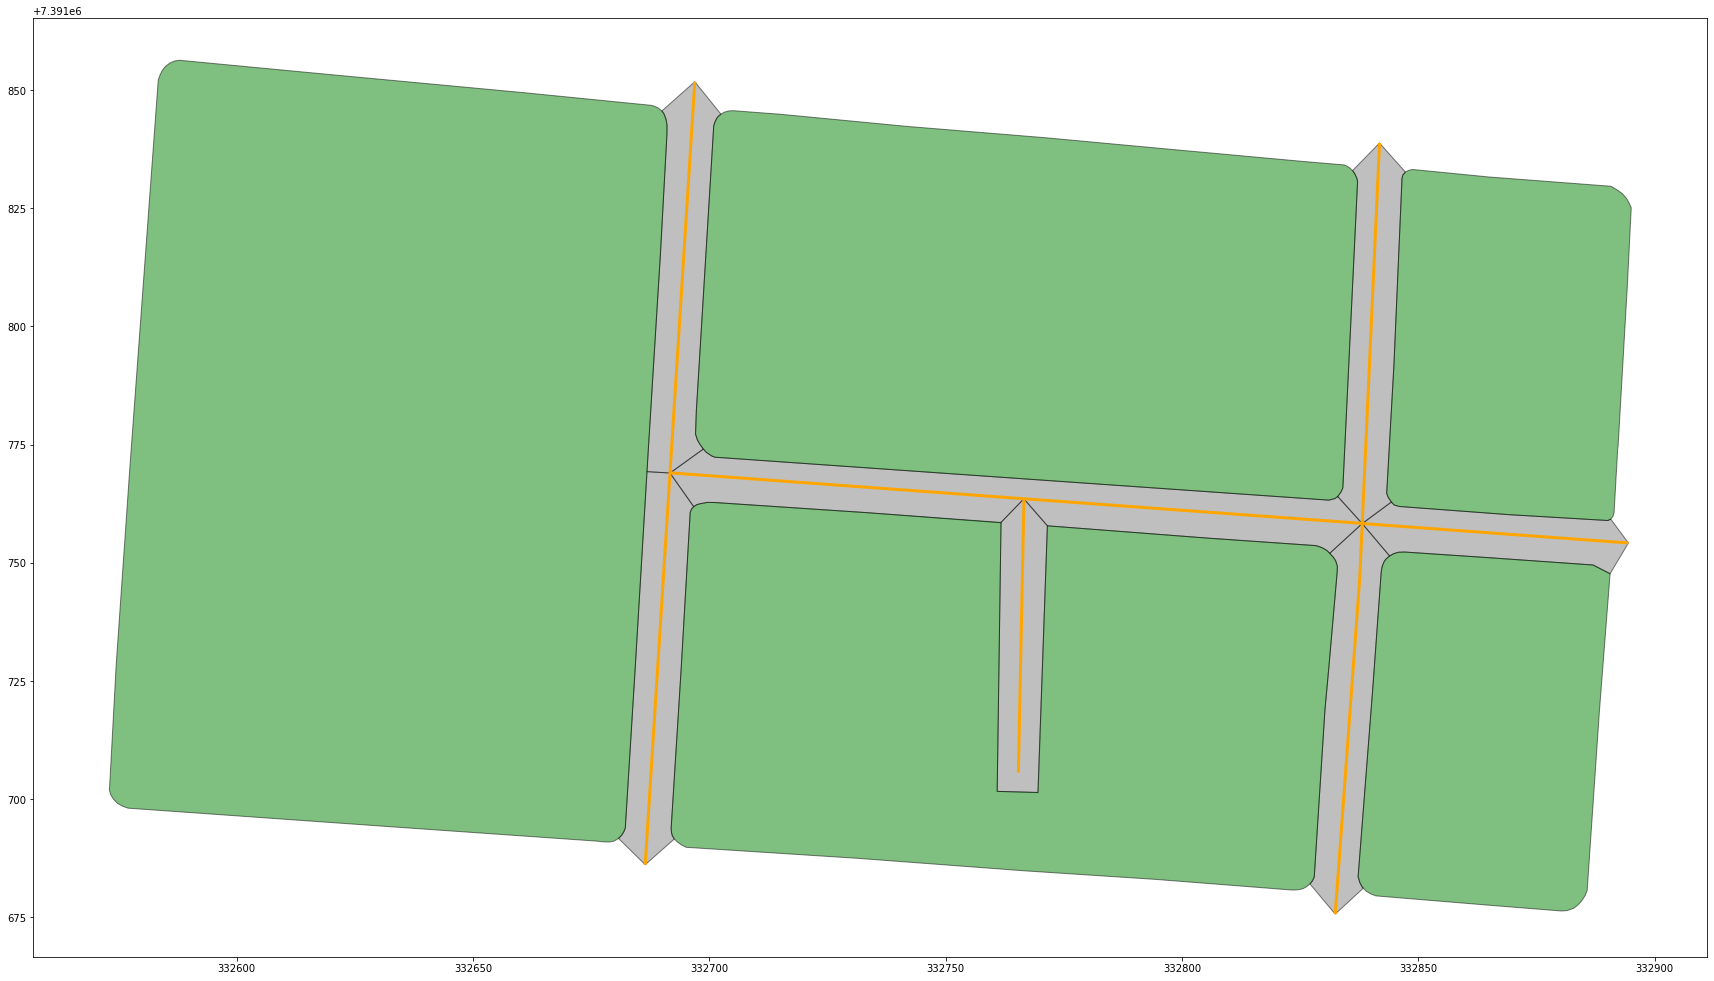

In [69]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=3)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

## Dividir para conquistar

Primeira estratégia seria dividir a linha central da via em pequenos segmentos para depois encontrar os pontos próximos nas quadras adjacentes

In [70]:
df_lvias.apply(lambda x: [x.geometry.length], axis=1)

0     [82.84273643904555]
1     [80.59425436230332]
2     [82.95592474412558]
3     [83.04766092811225]
4    [146.85587046999353]
5     [56.47167724829081]
6     [57.98145765525419]
dtype: object

Uma estratégia que pode parecer interessante seria gerar um ponto a cada 12 metros para medirmos. Isso excluiria do cálculo os segumentos de via menores que 12 metros. Esse valor pode ser reconsiderado

In [71]:
import math
from shapely.geometry import MultiPoint

In [72]:
[(((i)*12)+6+(16%12)/2) for i in range(math.floor(42/12))]

[8.0, 20.0, 32.0]

In [73]:
dist = 12.00

points = df_lvias.apply(lambda x: MultiPoint([x.geometry.interpolate(((i)*dist)+dist/2+(x.geometry.length%dist)/2) 
                                              for i in range(math.floor(x.geometry.length/dist))]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

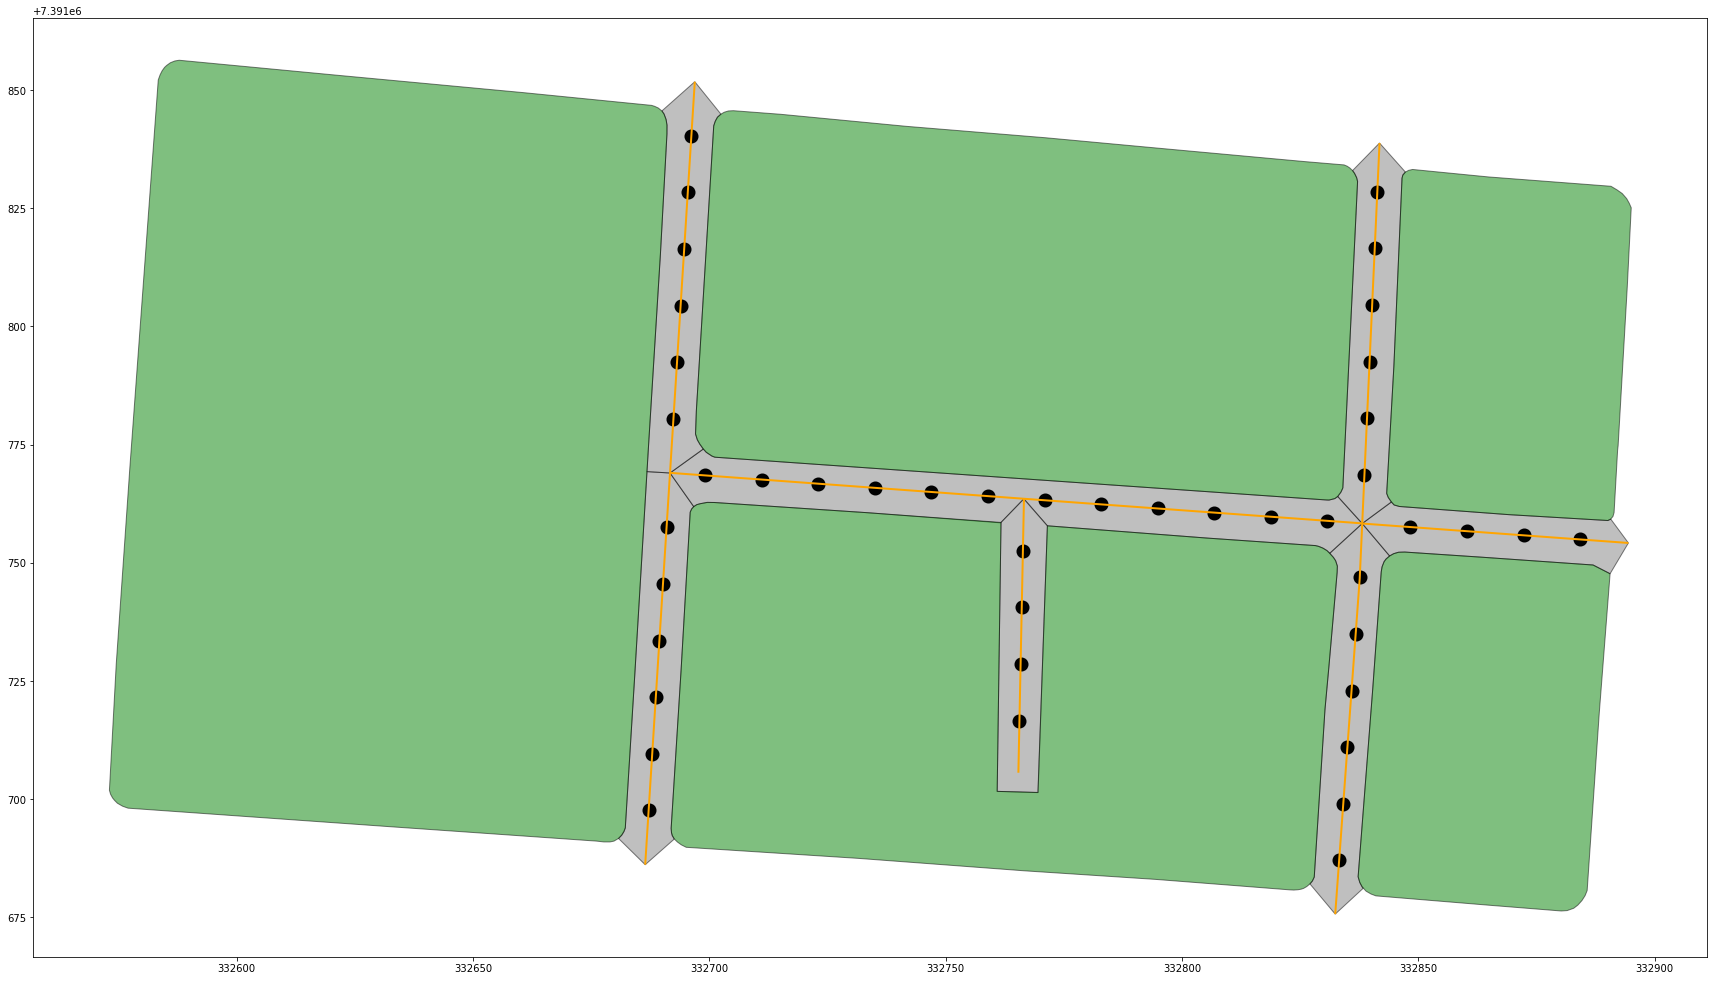

In [74]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')
df_points.plot(ax=ax, lw=4, marker='o', markersize=100, color='black')

Agora temos que relacionar esses pontos seu respectivo polígono de via para depois saber quais são as suas quadras adjacentes, para então medir a sua distância até elas

## Relacionando o ponto ao seu polígono de via

In [75]:
gpd.sjoin(df_points, df_pvias, how='left', op='intersects')

,geometry,index_right
0,"MULTIPOINT (332837.605 7391746.888, 332836.738...",0
1,"MULTIPOINT (332841.319 7391828.522, 332840.773...",4
2,"MULTIPOINT (332696.176 7391840.326, 332695.418...",5
3,"MULTIPOINT (332690.929 7391757.491, 332690.171...",1
4,"MULTIPOINT (332699.095 7391768.481, 332711.063...",3
5,"MULTIPOINT (332848.333 7391757.553, 332860.301...",2
6,"MULTIPOINT (332766.328 7391752.553, 332766.084...",6


Seria interessante talvez termos um registro para cada ponto

In [76]:
points = df_points.apply(lambda x: list(x.geometry.geoms), axis=1)
df_p = gpd.GeoDataFrame(geometry=[item for sublist in points for item in sublist])

In [77]:
df_points = gpd.sjoin(df_p, df_pvias, how='left', op='intersects', rsuffix='pvias')
df_points

,geometry,index_pvias
0,POINT (332837.605 7391746.888),0
1,POINT (332836.738 7391734.920),0
2,POINT (332835.864 7391722.952),0
3,POINT (332834.990 7391710.984),0
4,POINT (332834.117 7391699.015),0
5,POINT (332833.243 7391687.047),0
6,POINT (332841.319 7391828.522),4
7,POINT (332840.773 7391816.535),4
8,POINT (332840.228 7391804.547),4
9,POINT (332839.683 7391792.560),4


## Relacionando as quadras adjacentes ao polígono de vias

Agora precisamos saber quais são as quadras adjacentes ao polígono de vias e essa é uma das vantagens de se trabalhar com um polígono e não com linhas para representar vias.

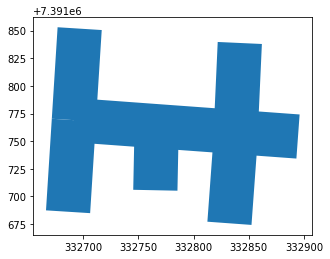

In [78]:
df_lvias.buffer(20, cap_style=2).plot()

In [79]:
df_points

,geometry,index_pvias
0,POINT (332837.605 7391746.888),0
1,POINT (332836.738 7391734.920),0
2,POINT (332835.864 7391722.952),0
3,POINT (332834.990 7391710.984),0
4,POINT (332834.117 7391699.015),0
5,POINT (332833.243 7391687.047),0
6,POINT (332841.319 7391828.522),4
7,POINT (332840.773 7391816.535),4
8,POINT (332840.228 7391804.547),4
9,POINT (332839.683 7391792.560),4


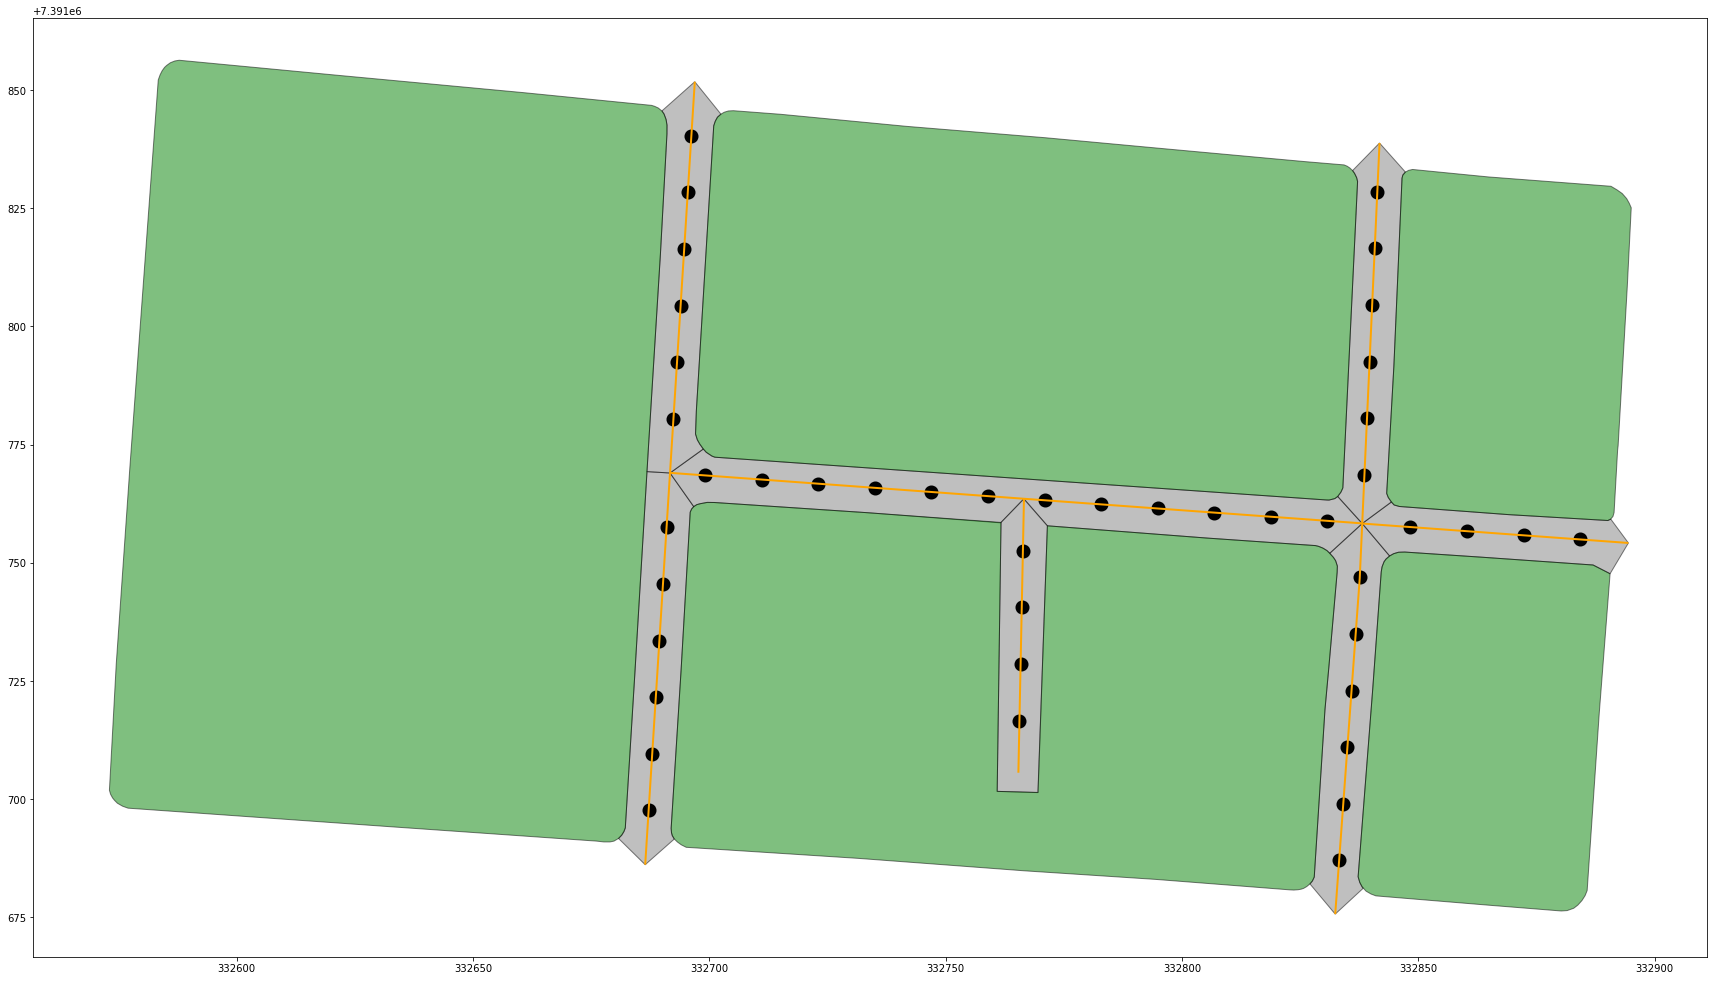

In [82]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')
df_points.plot(ax=ax, lw=4, marker='o', markersize=100, color='black')

In [83]:
df_pvia_quadra = gpd.sjoin(df_pvias, df_quadras, how='left', op='intersects', rsuffix='quadra')
df_pvia_quadra.index.name = 'id'
df_pvia_quadra['via'] = df_pvia_quadra.index

In [84]:
df_pvia_quadra

,geometry,index_quadra,qe_escala,qe_ano_ref,qe_area,qe_id,qe_tipo,via
id,,,,,,,,
0,"POLYGON ((332838.357 7391681.144, 332832.412 7...",2,1:1.000,2004,9975.0,12243.0,Quadra,0
0,"POLYGON ((332838.357 7391681.144, 332832.412 7...",3,1:1.000,2004,3523.0,12242.0,Quadra,0
1,"POLYGON ((332692.571 7391691.545, 332686.408 7...",1,1:1.000,2004,17156.0,12244.0,Quadra,1
1,"POLYGON ((332692.571 7391691.545, 332686.408 7...",2,1:1.000,2004,9975.0,12243.0,Quadra,1
2,"POLYGON ((332890.572 7391747.677, 332886.974 7...",3,1:1.000,2004,3523.0,12242.0,Quadra,2
2,"POLYGON ((332890.572 7391747.677, 332886.974 7...",4,1:1.000,2004,3427.0,9221.0,Quadra,2
3,"POLYGON ((332831.250 7391752.001, 332830.666 7...",2,1:1.000,2004,9975.0,12243.0,Quadra,3
3,"POLYGON ((332831.250 7391752.001, 332830.666 7...",0,1:1.000,2004,9889.0,12544.0,Quadra,3
4,"POLYGON ((332844.298 7391762.855, 332838.124 7...",0,1:1.000,2004,9889.0,12544.0,Quadra,4


In [85]:
# df_pvia_quadra_splited = gpd.overlay(gpd.GeoDataFrame(geometry=df_lvias.buffer(40, cap_style=2)), df_pvia_quadra, how='intersection')
# df_pvia_quadra_splited

Agora podemos relacionar os pontos ao DataFrame de poligonos de vias e quadras que acabamos de criar

## Calculando as distâncias

Agora podemos a partir de cada ponto, calcular a distância para cada quadra adjacente ao seu respectivo polígono de via.

Na maioria dos casos vamos ter apenas duas quadras adjacentes, mas é possível acontecer casos em que há apenas uma e mais do que duas.

Nos casos onde só exista uma quadra adjacente podemos desconsiderar o cálculo. 

Nos casos onde ocorrerem mais do que duas quadras adjacentes, vamos utilizar as duas medidas mais próximas, o que faz sentido, uma vez que buscamos a largura mínima da via.


In [86]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split

In [51]:
# def calc_distancia(p):
#     quadras = list(df_pvia_quadra[df_pvia_quadra.index == p.index_pvias].index_quadra)
#     quadras = df_quadras[df_quadras.index.isin(quadras)]
#     pontos  = []
    
#     for i, row in quadras.iterrows():
#         pontos.append(nearest_points(p.geometry, row.geometry)[1])
        
#     return LineString(pontos)

# df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))

In [87]:
def calc_distancia(p):
    quadras = list(df_pvia_quadra[df_pvia_quadra.via == p.index_pvias].index_quadra)
    quadras = df_quadras[df_quadras.index.isin(quadras)]
    pontos  = []
    
    for i, row in quadras.iterrows():
        pontos.append(nearest_points(p.geometry, row.geometry)[1])
    
    if len(pontos) == 2:   
        return LineString(pontos)
    elif len(pontos) > 2:  
        bd = split(MultiPoint(pontos).convex_hull.boundary, MultiPoint(pontos))
        return min(bd, key=(lambda x: x.length))
    else:
        return None
    

# df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))
df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))

In [88]:
df_dists = df_dists[~df_dists.is_empty]

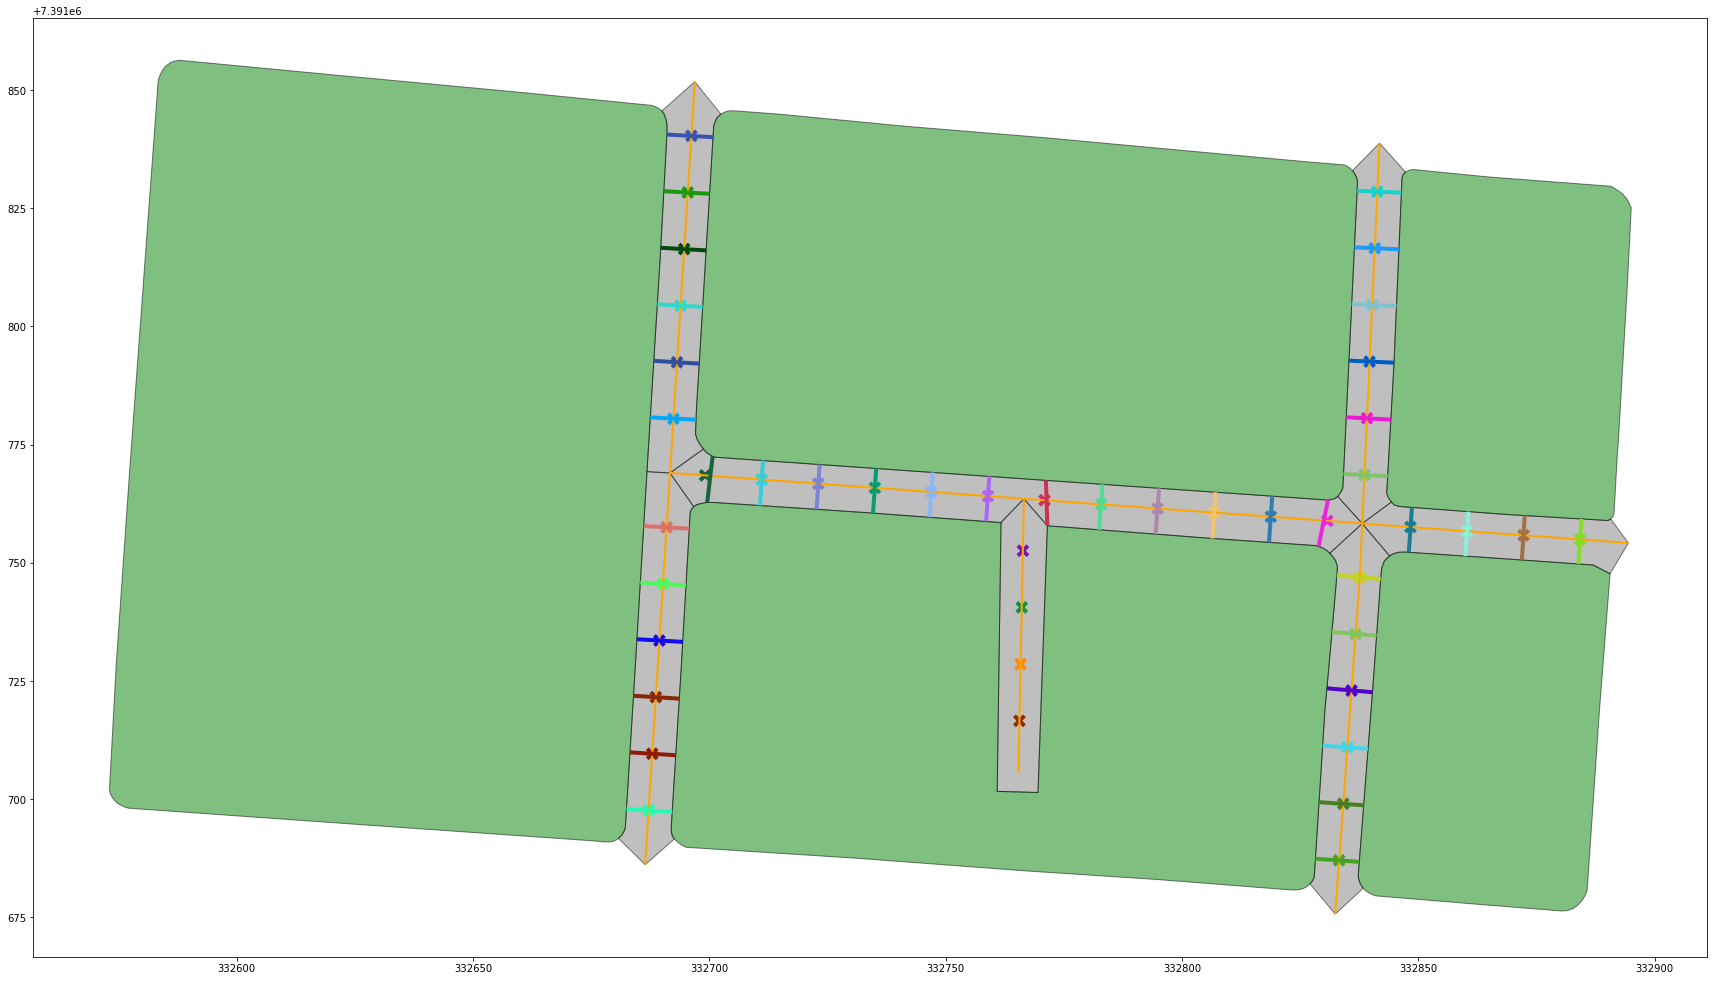

In [90]:
import numpy as np
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

c = np.random.rand(len(df_dists), 3)

df_dists.plot(ax=ax,lw=4, color=c)
df_points.plot(ax=ax, lw=4, marker='x', markersize=100, color=c)

In [91]:
# df_dists.length